# Identifying a promising tariff plan for a telecom company.

**Project Description**

Clients are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money.

**Task**

It is necessary to analyze customer behavior and draw a conclusion about which tariff is better.

Конечно, я выделил названия таблиц и колонок красным цветом:

**Data Description**

Table: **users** (user information):

- **user_id**: unique user identifier
- **first_name**: user's first name
- **last_name**: user's last name
- **age**: user's age (years)
- **reg_date**: tariff activation date (day, month, year)
- **churn_date**: date of discontinuation of the tariff (if the value is missing, the tariff was still active at the time of data extraction)
- **city**: user's city of residence
- **tariff**: tariff plan name

Table: **calls** (call information):

- **id**: unique call number
- **call_date**: call date
- **duration**: call duration in minutes
- **user_id**: user identifier who made the call

Table: **messages** (message information):

- **id**: unique message number
- **message_date**: message date
- **user_id**: user identifier who sent the message

Table: **internet** (internet session information):

- **id**: unique session number
- **mb_used**: volume of internet traffic spent per session (in megabytes)
- **session_date**: internet session date
- **user_id**: user identifier

Table: **tariffs** (tariff information):

- **tariff_name**: tariff name
- **rub_monthly_fee**: monthly subscription fee in rubles
- **minutes_included**: number of minutes of calls included in the monthly subscription fee
- **messages_included**: number of messages included in the monthly subscription fee
- **mb_per_month_included**: volume of internet traffic included in the monthly subscription fee (in megabytes)
- **rub_per_minute**: cost of a minute of call above the tariff package (for example, if the tariff includes 100 minutes of calls per month, then from the 101st minute, a fee will be charged)
- **rub_per_message**: cost of sending a message above the tariff package
- **rub_per_gb**: cost of additional gigabyte of internet traffic above the tariff package (1 gigabyte = 1024 megabytes)

## Studying Data from the File

Let's import the necessary libraries and take a look at the tables.

In [37]:
from scipy import stats as st
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt


df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

df_all = [df_calls, df_internet, df_messages, df_tariffs, df_users]

for i in df_all:
    print(i.info())
    display(i.head())
    print('*' * 100)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


****************************************************************************************************


Let's check if there are any missing values in the tables.

In [38]:
for i in df_all:
    print(i.isna().mean())
    print('*' * 100)

id           0.0
call_date    0.0
duration     0.0
user_id      0.0
dtype: float64
****************************************************************************************************
Unnamed: 0      0.0
id              0.0
mb_used         0.0
session_date    0.0
user_id         0.0
dtype: float64
****************************************************************************************************
id              0.0
message_date    0.0
user_id         0.0
dtype: float64
****************************************************************************************************
messages_included        0.0
mb_per_month_included    0.0
minutes_included         0.0
rub_monthly_fee          0.0
rub_per_gb               0.0
rub_per_message          0.0
rub_per_minute           0.0
tariff_name              0.0
dtype: float64
****************************************************************************************************
user_id       0.000
age           0.000
churn_date    0.924
city          0.

There are only missing values in the `users` table, in the `churn_date` column. This means that the subscribers are still active. Let's not change this column for now.

Let's check if there are any duplicates.

In [39]:
for i in df_all:
    print(i.duplicated().sum())

0
0
0
0
0


There are no duplicates.

### Conclusion

So, we have 5 tables. They are free of missing values and duplicates. Next step is data preprocessing.

In the `df_calls` and `df_internet` tables, there are zero values. This is not an error: zeros indicate missed calls and unsuccessful internet connections, so they don't need to be removed.

## Data Preprocessing

Let's change the column name in the `df_tariffs` table.

In [40]:
df_tariffs = df_tariffs.rename(columns={'tariff_name': 'tariff'})

Since the operator always rounds up each call to the nearest minute, let's reflect this in the `df_calls` table.

In [41]:
df_calls['duration'] = (df_calls['duration']).apply(math.ceil)

Let's convert the data to the appropriate types.

In [42]:
#1. df_calls
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls['duration'] = df_calls['duration'].astype(int)

#2. df_internet
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

#3. df_messages
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

#5. df_users
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

**Find the number of calls made and minutes used per month.**

First, let's add a new column with the month to the `df_calls` table.

In [43]:
df_calls['month'] = df_calls['call_date'].dt.month

Let's add a column with the tariff to the calls table.

In [44]:
df_calls = df_calls.merge(df_users[['user_id', 'tariff']], on='user_id')

Let's create a pivot table for the number and duration of calls.

In [45]:
df_calls_income = df_calls.pivot_table(index=['tariff', 'user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index()
df_calls_income.head()

,tariff,user_id,month,count,sum
,,,,duration,duration
0,smart,1001,11,59,430
1,smart,1001,12,63,414
2,smart,1002,6,15,117
3,smart,1002,7,26,214
4,smart,1002,8,42,289


Let's change the column names.

In [46]:
df_calls_income.columns = ['tariff', 'user_id', 'month', 'duration_count', 'duration_sum']

**Find the number of messages sent per month.**

First, let's add a new column with the month to the `df_messages` table.

In [47]:
df_messages['month'] = df_messages['message_date'].dt.month

Let's add a column with the tariff to the calls table.

In [48]:
df_messages = df_messages.merge(df_users[['user_id', 'tariff']], on='user_id')

Let's create a pivot table for the number of messages.

In [49]:
df_messages_income = df_messages.pivot_table(index=['tariff', 'user_id', 'month'], values='message_date', aggfunc='count').reset_index()
df_messages_income.head()

,tariff,user_id,month,message_date
0,smart,1002,6,4
1,smart,1002,7,11
2,smart,1002,8,13
3,smart,1002,9,4
4,smart,1002,10,10


**Find the volume of internet traffic used per month.**

First, let's add a new column with the month to the `df_internet` table.

In [50]:
df_internet['month'] = df_internet['session_date'].dt.month

Let's add a column with the tariff to the calls table.

In [51]:
df_internet = df_internet.merge(df_users[['user_id', 'tariff']], on='user_id')

Let's create a pivot table for the total traffic volume.

In [52]:
df_internet_income = df_internet.pivot_table(index=['tariff', 'user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()
df_internet_income.head()

,tariff,user_id,month,mb_used
0,smart,1001,11,18429.34
1,smart,1001,12,14036.66
2,smart,1002,6,10856.82
3,smart,1002,7,17580.10
4,smart,1002,8,20319.26


Let's merge the pivot tables into one. We'll use the calls table as the base.

In [53]:
df_income = df_calls_income
df_income = df_income.merge(df_messages_income, on=['tariff', 'user_id', 'month'], how='outer')
df_income = df_income.merge(df_internet_income, on=['tariff', 'user_id', 'month'], how='outer')
df_income.head()

,tariff,user_id,month,duration_count,duration_sum,message_date,mb_used
0,smart,1001,11,59.0,430.0,NaN,18429.34
1,smart,1001,12,63.0,414.0,NaN,14036.66
2,smart,1002,6,15.0,117.0,4.0,10856.82
3,smart,1002,7,26.0,214.0,11.0,17580.10
4,smart,1002,8,42.0,289.0,13.0,20319.26


Let's check for missing values.

In [54]:
df_income.isna().sum()

tariff              0
user_id             0
month               0
duration_count     40
duration_sum       40
message_date      497
mb_used            11
dtype: int64

Let's rename the column `message_date` to `message_count` and change all dates to 1, and empty values to 0.

In [55]:
df_income = df_income.rename(columns={'message_date': 'message_count'})

df_income['message_count'] = df_income['message_count'].fillna(0)

df_income.loc[(df_income['message_count'] != 0), 'message_count'] = 1
df_income['message_count'] = df_income['message_count'].astype(int)
df_income.head()

,tariff,user_id,month,duration_count,duration_sum,message_count,mb_used
0,smart,1001,11,59.0,430.0,0,18429.34
1,smart,1001,12,63.0,414.0,0,14036.66
2,smart,1002,6,15.0,117.0,1,10856.82
3,smart,1002,7,26.0,214.0,1,17580.10
4,smart,1002,8,42.0,289.0,1,20319.26


Let's change the missing values to 0 in the columns `duration_count`, `duration_sum`, and `mb_used`.

In [56]:
df_income['duration_count'] = df_income['duration_count'].fillna(0)
df_income['duration_sum'] = df_income['duration_sum'].fillna(0)
df_income['mb_used'] = df_income['mb_used'].fillna(0)

Let's check for missing values.

In [57]:
df_income.isna().sum()

tariff            0
user_id           0
month             0
duration_count    0
duration_sum      0
message_count     0
mb_used           0
dtype: int64

Based on the tariff, let's add the necessary information from the `df_tariffs` table.

In [58]:
df_income = df_income.merge(df_tariffs, on='tariff')
df_income.head()

,tariff,user_id,month,duration_count,duration_sum,message_count,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,smart,1001,11,59.0,430.0,0,18429.34,50,15360,500,550,200,3,3
1,smart,1001,12,63.0,414.0,0,14036.66,50,15360,500,550,200,3,3
2,smart,1002,6,15.0,117.0,1,10856.82,50,15360,500,550,200,3,3
3,smart,1002,7,26.0,214.0,1,17580.10,50,15360,500,550,200,3,3
4,smart,1002,8,42.0,289.0,1,20319.26,50,15360,500,550,200,3,3


**Find the monthly revenue from each user.**

First, let's find the number of calls exceeding the limit and add them to a new column.

In [59]:
df_income['duration_more_tarrif'] = df_income['duration_sum'] - df_income['minutes_included']
df_income.loc[(df_income['duration_more_tarrif'] < 0), 'duration_more_tarrif'] = 0

In [60]:
np.maximum(0,(df_income['duration_sum'] - df_income['minutes_included']))

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3209    0.0
3210    0.0
3211    0.0
3212    0.0
3213    0.0
Length: 3214, dtype: float64

Let's find the number of messages exceeding the limit and add them to a new column.

In [61]:
df_income['messages_more_tarrif'] = df_income['message_count'] - df_income['messages_included']
df_income.loc[(df_income['messages_more_tarrif'] < 0), 'messages_more_tarrif'] = 0

Now let's do the same for internet traffic and add it to a new column.

In [62]:
df_income['internet_more_tarrif'] = df_income['mb_used'] - df_income['mb_per_month_included']
df_income.loc[(df_income['internet_more_tarrif'] < 0), 'internet_more_tarrif'] = 0

In [63]:
df_income.head()

,tariff,user_id,month,duration_count,duration_sum,message_count,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,duration_more_tarrif,messages_more_tarrif,internet_more_tarrif
0,smart,1001,11,59.0,430.0,0,18429.34,50,15360,500,550,200,3,3,0.0,0,3069.34
1,smart,1001,12,63.0,414.0,0,14036.66,50,15360,500,550,200,3,3,0.0,0,0.00
2,smart,1002,6,15.0,117.0,1,10856.82,50,15360,500,550,200,3,3,0.0,0,0.00
3,smart,1002,7,26.0,214.0,1,17580.10,50,15360,500,550,200,3,3,0.0,0,2220.10
4,smart,1002,8,42.0,289.0,1,20319.26,50,15360,500,550,200,3,3,0.0,0,4959.26


Let's calculate the revenue.
We'll multiply the minutes, messages, and excess traffic by the tariff.
We'll convert traffic from MB to GB and round up to the nearest integer.
Then, we'll add them all up and add the subscription fee. The result will be the total revenue in a new column.

In [64]:
df_income['income_total'] = (df_income['duration_more_tarrif'] * df_income['rub_per_minute']) + (df_income['messages_more_tarrif'] * df_income['rub_per_message']) + (((df_income['internet_more_tarrif'] / 1024).apply(math.ceil)) * df_income['rub_per_gb']) + df_income['rub_monthly_fee']
df_income.head()

,tariff,user_id,month,duration_count,duration_sum,message_count,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,duration_more_tarrif,messages_more_tarrif,internet_more_tarrif,income_total
0,smart,1001,11,59.0,430.0,0,18429.34,50,15360,500,550,200,3,3,0.0,0,3069.34,1150.0
1,smart,1001,12,63.0,414.0,0,14036.66,50,15360,500,550,200,3,3,0.0,0,0.00,550.0
2,smart,1002,6,15.0,117.0,1,10856.82,50,15360,500,550,200,3,3,0.0,0,0.00,550.0
3,smart,1002,7,26.0,214.0,1,17580.10,50,15360,500,550,200,3,3,0.0,0,2220.10,1150.0
4,smart,1002,8,42.0,289.0,1,20319.26,50,15360,500,550,200,3,3,0.0,0,4959.26,1550.0


### Conclusion

We renamed columns and changed data types. We created several pivot tables for each tariff direction and also made a general table with all the necessary data. We added the total revenue to the table. Let's move on to data analysis.

## Data Analysis

Let's take a look at the description of the table.

In [65]:
df_income.describe()

,user_id,month,duration_count,duration_sum,message_count,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,duration_more_tarrif,messages_more_tarrif,internet_more_tarrif,income_total
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.0,3214.000000,3214.000000
mean,1251.590230,8.317362,63.038892,451.244866,0.845364,17207.612859,341.148102,20067.405103,1266.179216,979.060361,184.676416,2.387057,2.387057,28.854698,0.0,2141.032184,1517.009023
std,144.659172,2.905413,33.236368,241.909978,0.361614,7570.958771,438.044726,7082.491569,1152.749279,645.539596,23.054986,0.922199,0.922199,73.077172,0.0,3407.192129,798.489284
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,0.000000,0.0,0.000000,550.000000
25%,1125.000000,6.000000,40.000000,282.000000,1.000000,12491.890000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,0.000000,0.0,0.000000,750.000000
50%,1253.000000,9.000000,62.000000,443.000000,1.000000,16943.175000,50.000000,15360.000000,500.000000,550.000000,200.000000,3.000000,3.000000,0.000000,0.0,0.000000,1619.500000
75%,1378.750000,11.000000,82.000000,589.000000,1.000000,21424.625000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,0.000000,0.0,3550.732500,1950.000000
max,1499.000000,12.000000,244.000000,1673.000000,1.000000,49745.690000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,935.000000,0.0,23192.450000,6671.000000


The table shows that the majority of subscribers do not exceed the limits for calls and messages. Half of them do not exceed the internet limit.

**Let's see how calls, messages, internet, and revenue affect each other.**

**Smart Tariff**

In [66]:
df_income_smart = df_income.query('tariff == "smart"')
print(df_income_smart[['duration_sum', 'message_count', 'mb_used', 'income_total']].corr())

               duration_sum  message_count   mb_used  income_total
duration_sum       1.000000       0.020943  0.340519      0.411425
message_count      0.020943       1.000000  0.011577     -0.010840
mb_used            0.340519       0.011577  1.000000      0.847751
income_total       0.411425      -0.010840  0.847751      1.000000


The traffic has the most significant impact on revenue at 0.85. This means that the more traffic, the higher the revenue. It's logical.
Calls have less influence.
Messages have almost no impact.

**Ultra Tariff**

In [67]:
df_income_ultra = df_income.query('tariff == "ultra"')
print(df_income_ultra[['duration_sum', 'message_count', 'mb_used', 'income_total']].corr())

               duration_sum  message_count   mb_used  income_total
duration_sum       1.000000       0.018719  0.177775      0.090650
message_count      0.018719       1.000000 -0.018834     -0.121952
mb_used            0.177775      -0.018834  1.000000      0.620143
income_total       0.090650      -0.121952  0.620143      1.000000


Internet has a weaker impact on revenue compared to the Smart tariff, but still significant.
Calls and messages have almost no impact on revenue.

**Let's plot graphs for calls, messages, internet, and revenue, and find the variance and standard deviation.**

**1. Calls**

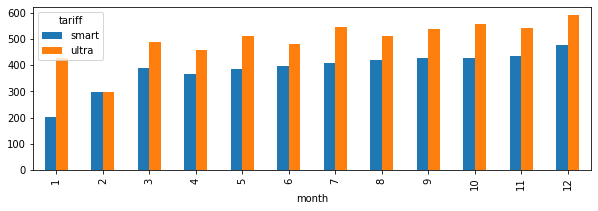

In [68]:
df_calls_mean = df_income.pivot_table(index='month', columns='tariff', values='duration_sum', aggfunc='mean').reset_index()
df_calls_mean.plot(kind='bar', x='month', figsize=(10, 3))

In [69]:
variance_calls_smart = np.var(df_income_smart['duration_sum'])
variance_calls_ultra = np.var(df_income_ultra['duration_sum'])

std_calls_smart = np.std(df_income_smart['duration_sum'])
std_calls_ultra = np.std(df_income_ultra['duration_sum'])

print('Дисперсия продолжительности звонков smart', variance_calls_smart)
print('Стандартное отклонение продолжительности звонков smart', std_calls_smart)
print()
print('Дисперсия продолжительности звонков ultra', variance_calls_ultra)
print('Стандартное отклонение продолжительности звонков ultra', std_calls_ultra)

Дисперсия продолжительности звонков smart 36203.06665209469
Стандартное отклонение продолжительности звонков smart 190.27103471651876

Дисперсия продолжительности звонков ultra 100771.2236172022
Стандартное отклонение продолжительности звонков ultra 317.44483554974113


In [70]:
df_income_smart['user_id'].nunique()

350

Let's plot a histogram of the distribution of call duration for the Smart tariff.

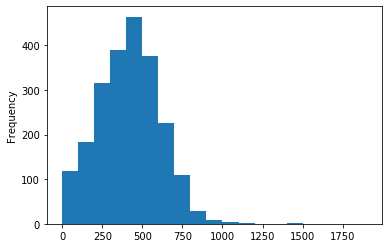

In [71]:
df_income_smart['duration_sum'].plot(kind='hist', bins=range(0, 2000, 100))

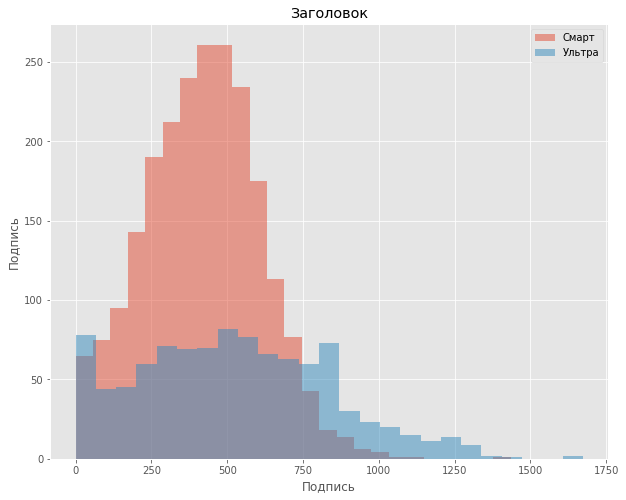

In [72]:
plt.style.use('ggplot') 

df_income.groupby('tariff')['duration_sum'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Смарт', 'Ультра'])
plt.title('Заголовок')
plt.xlabel('Подпись')
plt.ylabel('Подпись')

plt.show()

The histogram is normally distributed, with a slight deviation to the right. A small portion of calls exceeds 1000 minutes per month.

Let's plot a histogram of the distribution of call duration for the Ultra tariff.

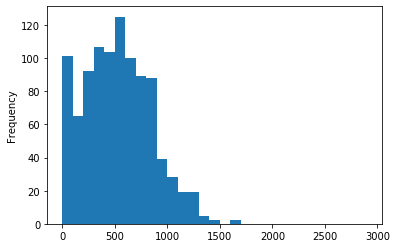

In [364]:
df_income_ultra['duration_sum'].plot(kind='hist', bins=range(0, 3000, 100))

The histogram shows that all users stay within the call limit (3000 minutes according to the tariff). Almost no one talks more than 1500 minutes per month.

**2. Messages**

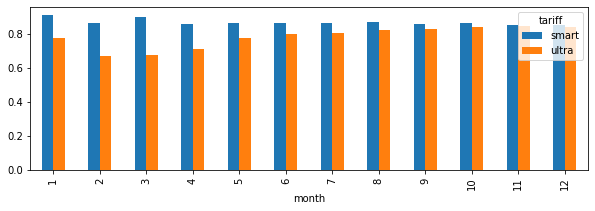

In [365]:
df_messages_mean = df_income.pivot_table(index='month', columns='tariff', values='message_count', aggfunc='mean').reset_index()
df_messages_mean.plot(kind='bar', x='month', figsize=(10, 3))

In [366]:
variance_messages_smart = np.var(df_income_smart['message_count'])
variance_messages_ultra = np.var(df_income_ultra['message_count'])

std_messages_smart = np.std(df_income_smart['message_count'])
std_messages_ultra = np.std(df_income_ultra['message_count'])

print('Дисперсия кол-ва смс smart', variance_messages_smart)
print('Стандартное отклонение кол-ва смс smart', std_messages_smart)
print()
print('Дисперсия кол-ва смс ultra', variance_messages_ultra)
print('Стандартное отклонение кол-ва смс ultra', std_messages_ultra)

Дисперсия кол-ва смс smart 0.11876039184122342
Стандартное отклонение кол-ва смс smart 0.34461629654040365

Дисперсия кол-ва смс ultra 0.1556855368600067
Стандартное отклонение кол-ва смс ultra 0.394570065843833


Let's plot a histogram of the distribution of messages for the Smart tariff.

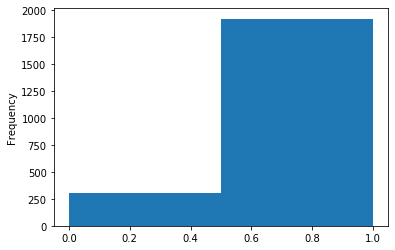

In [367]:
df_income_smart['message_count'].plot(kind='hist', bins=2)

Let's plot a histogram of the distribution of messages for the Ultra tariff.

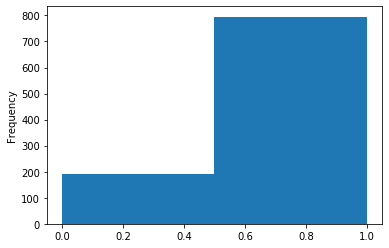

In [368]:
df_income_ultra['message_count'].plot(kind='hist', bins=2)

On both histograms, it's noticeable that there are subscribers who don't send any messages at all. The proportion of subscribers who don't send messages is higher for the Ultra tariff.

**3. Internet**

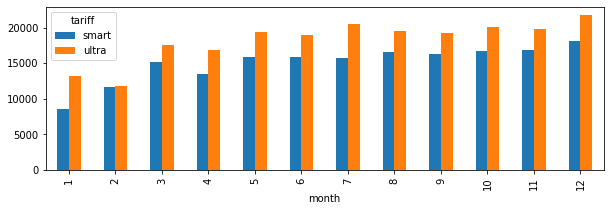

In [369]:
df_internet_mean = df_income.pivot_table(index='month', columns='tariff', values='mb_used', aggfunc='mean').reset_index()
df_internet_mean.plot(kind='bar', x='month', figsize=(10, 3))

In [370]:
variance_internet_smart = np.var(df_income_smart['mb_used'])
variance_internet_ultra = np.var(df_income_ultra['mb_used'])

std_internet_smart = np.std(df_income_smart['mb_used'])
std_internet_ultra = np.std(df_income_ultra['mb_used'])

print('Дисперсия интернета smart', variance_internet_smart)
print('Стандартное отклонение интернета smart', std_internet_smart)
print()
print('Дисперсия интернета ultra', variance_internet_ultra)
print('Стандартное отклонение интернета ultra', std_internet_ultra)

Дисперсия интернета smart 34447035.49528493
Стандартное отклонение интернета smart 5869.159692433401

Дисперсия интернета ultra 101647713.26174639
Стандартное отклонение интернета ultra 10082.049060669482


Let's plot a histogram of the distribution of internet traffic for the Smart tariff.

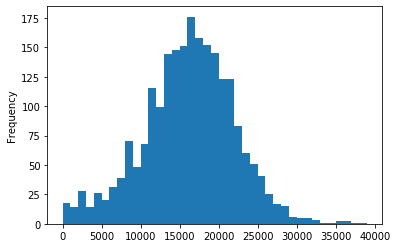

In [371]:
df_income_smart['mb_used'].plot(kind='hist', bins=range(0, 40000, 1000))

The histogram is normally distributed. However, a large portion of subscribers exceed the 15GB traffic limit.

Let's plot a histogram of the distribution of internet traffic for the Ultra tariff.

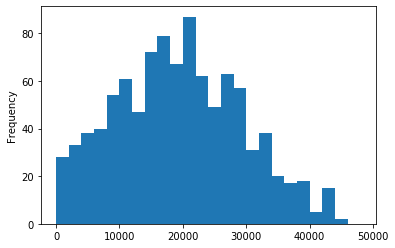

In [372]:
df_income_ultra['mb_used'].plot(kind='hist', bins=range(0, 50000, 2000))

Subscribers of the Ultra tariff more often stay within the 30GB limit, but there are also subscribers who exceed it.

**4. Revenue**

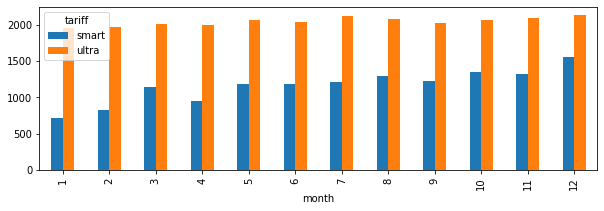

In [373]:
df_income_mean = df_income.pivot_table(index='month', columns='tariff', values='income_total', aggfunc='mean').reset_index()
df_income_mean.plot(kind='bar', x='month', figsize=(10, 3))

In [374]:
variance_income_smart = np.var(df_income_smart['income_total'])
variance_income_ultra = np.var(df_income_ultra['income_total'])

std_income_smart = np.std(df_income_smart['income_total'])
std_income_ultra = np.std(df_income_ultra['income_total'])

print('Дисперсия выручки smart', variance_income_smart)
print('Стандартное отклонение выручки smart', std_income_smart)
print()
print('Дисперсия выручки ultra', variance_income_ultra)
print('Стандартное отклонение выручки ultra', std_income_ultra)

Дисперсия выручки smart 661620.0229295266
Стандартное отклонение выручки smart 813.4002845644491

Дисперсия выручки ultra 141373.07325620347
Стандартное отклонение выручки ultra 375.9961080333192


Let's plot a histogram of the distribution of total revenue for the Smart tariff.

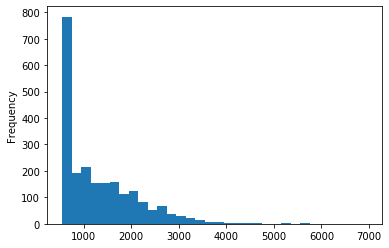

In [375]:
df_income_smart['income_total'].plot(kind='hist', bins=range(550, 7000, 200))

Many subscribers of the Smart tariff pay more than 550 rubles per month. Moreover, there are subscribers who pay more than the cost of the Ultra tariff. They should definitely consider changing their tariff to save money.

Let's plot a histogram of the distribution of total revenue for the Ultra tariff.

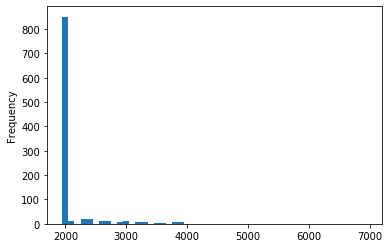

In [376]:
df_income_ultra['income_total'].plot(kind='hist', bins=range(1950, 7000, 100))

Almost all subscribers of the ultra tariff pay only a subscription fee, without additional services. There is a small part of subscribers who exceed the limits, but the share of such subscribers is significantly less than that of the smart tariff

<b>Let's find the number of subscribers on each tariff and the total revenue for the tariffs</b>

In [377]:
print('Итоговая выручка по тарифам')
print(df_income.pivot_table(index='tariff', values='income_total', aggfunc='sum'))
print()
print('Общее кол-во абонентов')
print(df_users.pivot_table(index='tariff', values='user_id', aggfunc='count'))

Итоговая выручка по тарифам
        income_total
tariff              
smart      2836567.0
ultra      2039100.0

Общее кол-во абонентов
        user_id
tariff         
smart       351
ultra       149


### Conclusion

The graphs show that the average value for all parameters is higher for the ultra tariff, except for the number of SMS. In terms of average number of SMS, the smart<br> tariff is in the lead
The variance in calls, SMS and traffic is greater for the ultra tariff. Smart tariff revenue dispersion is greater<br>
The revenue of the smart tariff is greatly influenced by traffic. I think that 15GB is not enough for many subscribers and they pay separately for additional traffic. Calls have less impact<br>
The ultra tariff's revenue will mainly come from the Internet. But here more subscribers meet the tariff standards than on smart<br>
More people use the smart tariff than the ultra tariff. And the total revenue for the smart tariff is higher.<br>
Constructed distribution histograms for calls, SMS, Internet and revenue

## Testing hypotheses

<b>Hypothesis 1<br>
 H0 - Average revenue of users of Ultra tariffs = average revenue of users of Smart tariffs<br>
</b>

We already have two ready-made tables

- df_income_smart
- df_income_ultra

Let's check the hypothesis

In [378]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    df_income_smart['income_total'], 
    df_income_ultra['income_total'],
    equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  3.798003235009034e-261
Отвергаем нулевую гипотезу


Because We don’t have a lot of data, so we can calculate more accurately using the mean() function

In [379]:
print(df_income_smart['income_total'].mean())
print(df_income_ultra['income_total'].mean())

1272.5737999102737
2070.1522842639592


The hypothesis was not confirmed. The average revenue of the smart tariff is almost two times less than that of the ultra tariff

<b>Hypothesis 2<br>
 H0 - Average revenue of users from Moscow = average revenue of users from other cities<br>
</b>

First, let's add the city to the table with revenue

In [380]:
df_income = df_income.merge(df_users[['user_id', 'city']], on='user_id')

Now let's make two separate tables:
1. Only Moscow
2. Other cities

In [381]:
df_income_moscow_city = df_income.query('city == "Москва"')
df_income_others_city = df_income.query('city != "Москва"')

Testing the hypothesis

In [382]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    df_income_moscow_city['income_total'], 
    df_income_others_city['income_total'],
    equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.425625168367989
Не получилось отвергнуть нулевую гипотезу


The hypothesis was confirmed, because pvalue turned out to be 42%
The revenue of Moscow and other cities is approximately the same

Let's double check

In [383]:
print(df_income_moscow_city['income_total'].mean())
print(df_income_others_city['income_total'].mean())

1539.1767594108019
1511.8056089127929


The difference is less than 100

### Conclusion

Hypothesis 1 was confirmed. The revenue between the two tariffs differs by almost two times<br>
Hypothesis 2 was not confirmed. Revenue between Moscow and other cities is not much different.

For two hypotheses, I used a method to test the hypothesis that the mean of two populations is equal based on samples taken from them: scipy.stats.ttest_ind (array1, array2,equal_var)

We are completing the project

## General conclusion

Having analyzed the data on 500 subscribers of the Megaline company, we draw the following conclusion.
1. The greatest revenue for the company comes from the smart tariff. Also, the smart tariff has a larger number of people.
2. Revenue from the ultra tariff is more stable than from the smart tariff. I assume that this is due to the fact that many smart tariff subscribers buy additional traffic.
3. The variance in calls, SMS and traffic is greater with the ultra tariff. The revenue dispersion of the smart tariff is greater. This means that smart tariff subscribers more often exceed the limits that are established with their tariff and, accordingly, overpay more often.
4. The hypothesis that the average revenue of users of Ultra and Smart tariffs are equal was not confirmed. On average, subscribers pay almost twice as much for the ultra tariff
5. The hypothesis that the average revenue of users from Moscow is equal to the revenue of users from other regions was confirmed. The difference in revenue between Moscow and other cities is no more than 100 rubles.

Having analyzed this sample, we come to the following conclusion:

The smart tariff is better than the ultra tariff, because... the revenue from this takrif is greater. The revenue of the smart tariff is 2.8 million rubles, the ultra tariff is 2 million rubles. Also, more subscribers use the smart tariff than the ultra tariff. 351 and 149 respectively.